In [1]:
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.svm import SVR

from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple

In [2]:
ORIGIN_BLOCKGROUP = 'o_bg'
GEO_ID = 'geoid'
AREA = 'area'
BLOCKGROUP_MODE_CHOICE = 'block_group'
BLOCKGROUP_AFFORDABILITY = 'key'
BLOCKGROUP = 'blockgroup'


### The following is new features list
DURATION = 'google_duration'
DISTANCE = 'trip_path_distance'
HOUSEHOLD_SIZE = 'hhsize'
RENT = 'hh_rent'
HOME_OWN = 'hh_own'
DEPART_TIME = 'depart_time'
NUMBER_CHILDREN = 'numchildren'
NUMBER_VEHICLE = 'vehicle_count'
FEMALE = 'gender_female'
MALE = 'gender_male'
WEEKDAY_AM = 'weekday_am'
WEEKDAY_MID = 'weekday_mid'
WEEKDAY_PM = 'weekday_pm'
WEEKDAY_LATE = 'weekday_late'
RESIDENCY_UNDER5 = 'residency_under5'
RESIDENCY_OVER5 = 'residency_over5'
INCOME_UNDER25 = 'income_under25'
INCOME_75_100 = 'income_75_100'
INCOME_OVER100 = 'income_over100'
RACE_WHITE = 'race_white'
TRIP_WEIGHT = 'trip_weight_revised'
DRIVE_ALONE_THRESHOLD = 'drive_alone_threshold'
DRIVE_ALONE = 'drive_alone'
###

# and TRIP_WEIGHT when summarizing the results
WEIGHTED_VALUES = 'weighted_values'


#rename:
MODE_INDEX = 'mode_index'
SCALED = 'scaled'
MODE_CHOIDE_SCORE = 'mode_choice_score'
AFFORDABILITY_SCORE = 'affordability_score'
ABOVE_MEDIAN = 'prop_driving_above_median'

FEATURES_LIST = [DURATION, DISTANCE, HOUSEHOLD_SIZE, RENT, HOME_OWN, DEPART_TIME, 
                NUMBER_CHILDREN, NUMBER_VEHICLE, FEMALE, MALE, 
                WEEKDAY_AM, WEEKDAY_MID, WEEKDAY_PM, WEEKDAY_LATE, 
                RESIDENCY_UNDER5, RESIDENCY_OVER5, INCOME_UNDER25, INCOME_75_100, INCOME_OVER100, 
                RACE_WHITE, TRIP_WEIGHT]
SCORES_LIST = [MODE_CHOIDE_SCORE, AFFORDABILITY_SCORE]
OUTCOME_LIST = [DRIVE_ALONE, DRIVE_ALONE_THRESHOLD]


# new mode choice name:
VIABLE = 'viable'
COST = 'cost'
WEIGHTED_COST = 'weighted_cost'
WEIGHT_FOR_COST = 'weight_for_cost'
WEIGHTED_VIABLE = 'weighted_viable'
MODE = 'mode'
DRIVING = 'driving'
BICYCLING = 'bicycling'
TRANSIT = 'transit'
WALKING = 'walking'

HOUSEHOLD_ID = 'hhid'
HOUSEHOLD_BLOCKGROUP = 'final_home_bg'
HOUSEHOLD_WEIGHT = 'hh_wt_revised'

In [3]:
def calculate_weighted_mean(input_dat, values_column, weights_column=TRIP_WEIGHT):
    """
    Similar to calculate_weighted_quantile, this function takes a Data Frame 
    with two column names (values_column and weights_column), 
    each of which represents a list of features and one weight column respectively,
    and computes the weighted mean the value. 
    The output will be one single number - weighted mean
    Input:
        input_dat: data frame with return values & weights
        values_column: name of the column with return values
        weights_column: name of the weights column
    Output:
        weighted mean of the value
    """
    input_dat = input_dat[[values_column, weights_column]].copy()   
    input_dat[WEIGHTED_VALUES] = input_dat[values_column] * input_dat[weights_column]
    
    return( input_dat[WEIGHTED_VALUES].sum() / input_dat[weights_column].sum() )

def calculate_weighted_quantile(input_dat, values_column, weights_column=TRIP_WEIGHT, quantile_val = 0.5):
    """
    This function takes a Data Frame with two columns, 
    one is value and the other is survey weight, 
    and computes the weighted quantile of the value. 
    The output will be one single value (right?) which is the value of 
    the quantile
    Input:
        input_dat: data frame with return values & weights
        values_column: name of the column with return values
        weights_column: name of the weights column
        quantile_val: quantile you want to know
    Output:
        single value of the desired quantile
    """
    input_dat = input_dat[[values_column, weights_column]].copy()
    input_dat = input_dat.dropna()
    input_dat = input_dat.sort_values(by = values_column)
    # normalized cumulative sum
    input_dat[CUMSUM_WEIGHT] = np.cumsum(input_dat[weights_column]) / input_dat[weights_column].sum()
    
    idx1 = input_dat[input_dat[CUMSUM_WEIGHT] <= quantile_val].index
    idx2 = input_dat[input_dat[CUMSUM_WEIGHT] >= quantile_val].index
    
    
    if ( len(idx1) != 0):
        if (idx1[len(idx1) - 1] == idx2[0]):
            #print("they are same")
            return(dummy.loc[idx2[0], MEAN_AGE])
        else: 
            #print("they are not the same")
            return( (input_dat.loc[idx1[len(idx1) - 1], values_column] + input_dat.loc[idx2[0], values_column]) / 2 ) 
    else: 
        # return zero if there's no value
        return(0)

In [164]:
# Load Scores data and create mode choice score and affordability scores
scores = pd.read_csv('trip_scores_out_of_psrc.csv')[[BLOCKGROUP_MODE_CHOICE, VIABLE, COST, MODE, TRIP_WEIGHT]]
scores = scores[scores[TRIP_WEIGHT] != 0]

scores.rename(columns={BLOCKGROUP_MODE_CHOICE: BLOCKGROUP}, inplace=True)
dummy_modes = pd.get_dummies(scores[MODE])
dummy_modes.loc[scores[MODE].isnull(), :] = np.nan
scores = pd.concat([scores, dummy_modes], axis = 1)

scores = scores.sort_values(BLOCKGROUP)
scores[WEIGHTED_COST] = np.where(scores[VIABLE] == 0.0, np.nan, scores[COST]) * scores[TRIP_WEIGHT]
scores[WEIGHT_FOR_COST] = np.where( scores[WEIGHTED_COST].isna(), np.nan, scores[TRIP_WEIGHT]) 
scores[WEIGHTED_VIABLE] = scores[VIABLE] * scores[TRIP_WEIGHT]
scores.head()

,blockgroup,viable,cost,mode,trip_weight_revised,bicycling,driving,transit,walking,weighted_cost,weight_for_cost,weighted_viable
19500,530330001001,0.0,16.018991,driving,1.062795,0.0,1.0,0.0,0.0,NaN,NaN,0.0
12430,530330001001,0.0,17.329684,driving,31.452233,0.0,1.0,0.0,0.0,NaN,NaN,0.0
18201,530330001002,0.0,8.113338,driving,16.913745,0.0,1.0,0.0,0.0,NaN,NaN,0.0
18197,530330001002,0.0,8.113338,driving,16.913745,0.0,1.0,0.0,0.0,NaN,NaN,0.0
4924,530330001002,0.0,13.663458,driving,13.354872,0.0,1.0,0.0,0.0,NaN,NaN,0.0


In [165]:
# looping over unique blockgroups
unique_clusters = scores[BLOCKGROUP].unique()
result_affordability = pd.DataFrame([])
for i in unique_clusters:        
    # choose for each cluster
    sub_cluster = scores[scores[BLOCKGROUP] == i]
    sub_cluster = sub_cluster.dropna(subset = [WEIGHTED_COST])
    one_row = np.array([i])
    if ( len(sub_cluster) == 0 ):
        one_row = np.append(one_row, np.nan)
    else:
        one_row = np.append(one_row, sub_cluster[WEIGHTED_COST].sum() / sub_cluster[WEIGHT_FOR_COST].sum() )
        
    one_row = pd.DataFrame(one_row.reshape(-1, len(one_row)), 
                              columns = [BLOCKGROUP] + [AFFORDABILITY_SCORE])
    result_affordability = result_affordability.append(one_row, ignore_index = True)
    
result_affordability = result_affordability.dropna(subset=[AFFORDABILITY_SCORE])

result_mode_choice = pd.DataFrame([])
for i in unique_clusters:        
    # choose for each cluster
    sub_cluster = scores[scores[BLOCKGROUP] == i]
    one_row = pd.DataFrame(np.array([i]), columns = [BLOCKGROUP])

    ### USE GROUPBY MEAN OF MODES, / VIABLE:
    mode_ratios = sub_cluster.groupby(MODE, as_index=True).agg(
    {
        VIABLE: 'mean'
    }).transpose().reset_index()
    
    mode_ratios = mode_ratios.drop(columns='index')
    
    one_row = pd.concat([one_row, mode_ratios], axis = 1)
    
    result_mode_choice = result_mode_choice.append(one_row, ignore_index = True)

#bicycling	0.039321
#driving	0.484660
#transit	0.164159
# walking	0.311861
    
result_mode_choice[MODE_CHOIDE_SCORE] = result_mode_choice[[DRIVING, BICYCLING, TRANSIT, WALKING]].mean(axis = 1) 

# result_mode_choice[MODE_CHOIDE_SCORE] = (result_mode_choice[DRIVING] * 0.484660 + 
# result_mode_choice[BICYCLING] * 0.039321 + result_mode_choice[TRANSIT] * 0.164159 + 
# result_mode_choice[WALKING] * 0.311861)





In [166]:
len(result_affordability)

401

In [167]:
len(result_mode_choice[MODE_CHOIDE_SCORE]) 

453

In [168]:
result_mode_choice.head()

,bicycling,blockgroup,driving,transit,walking,mode_choice_score
0,NaN,530330001001,0.000000,NaN,NaN,0.000000
1,NaN,530330001002,0.222222,NaN,NaN,0.222222
2,1.0,530330001003,0.482759,1.0,1.0,0.870690
3,1.0,530330001005,0.333333,1.0,1.0,0.833333
4,NaN,530330002002,0.588235,1.0,1.0,0.862745


(array([  39.,   86.,  143.,   84.,   31.,    9.,    3.,    3.,    1.,    2.]),
 array([  0.    ,   1.3325,   2.665 ,   3.9975,   5.33  ,   6.6625,
          7.995 ,   9.3275,  10.66  ,  11.9925,  13.325 ]),
 <a list of 10 Patch objects>)

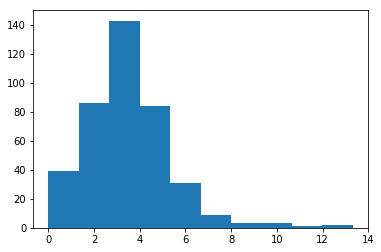

In [169]:
plt.hist(result_affordability[AFFORDABILITY_SCORE])

(array([  53.,    5.,    4.,   12.,    5.,   82.,   90.,  140.,   36.,   26.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

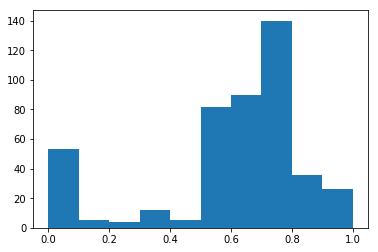

In [170]:
plt.hist(result_mode_choice[MODE_CHOIDE_SCORE])

## Now we are ready to load trip data and repreprocess and predict them

In [21]:
MODE_INDEX

'mode_index'

In [23]:
SCALED

'scaled'

In [20]:
result_mode_choice.columns

Index(['Unnamed: 0', 'blockgroup', 'driving', 'bicycling', 'transit',
       'walking', 'mode_index'],
      dtype='object')

In [29]:
# Steve's version, and the latest on Aug 15. 
AFFORDABILITY_BLOCKGROUP = 'key'
MODE_CHOICE_BLOCKGROUP = 'block_group'

result_mode_choice = pd.read_csv('true_final/wkday_mode_avail_default.csv')
result_mode_choice.rename(columns={MODE_CHOICE_BLOCKGROUP: BLOCKGROUP, 
                                   MODE_INDEX: MODE_CHOIDE_SCORE}, inplace=True)
result_affordability = pd.read_csv('true_final/wkday_affordability_default_rel.csv')
result_affordability.rename(columns={AFFORDABILITY_BLOCKGROUP: BLOCKGROUP,
                                    SCALED: AFFORDABILITY_SCORE}, inplace=True)
features_set = pd.merge(left=result_mode_choice, right=result_affordability, on=BLOCKGROUP)
features_set.head()


tr = pd.read_csv('df_Trip_Features.csv')
tr.rename(columns={ORIGIN_BLOCKGROUP: BLOCKGROUP}, inplace=True)
tr.head()
len(tr[BLOCKGROUP].unique())

152

In [30]:
def fit_and_evaluate_binary(input_model, title_label, input_dat, output_dat):
    
    """
    This function runs logistic regression, random forests classifier, support vector classifier
    using binary outcome
    """    
    
    input_model.fit(input_dat, output_dat)
    mode_scores = cross_val_score(input_model, input_dat, 
                              output_dat, 
                              scoring='accuracy', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0))

    #print("Accuracy for each K")
    #print(np.abs(mode_scores), "\n")
    print("Summary: " + title_label + " with 5-fold CV Accuracy: %0.2f (+/- %0.2f)" % 
          (np.abs(mode_scores).mean(), np.abs(mode_scores).std() * 2))
    print("\n")
    
    return ([np.abs(mode_scores).mean(), np.abs(mode_scores).std()])

In [31]:
def run_and_diagnose(input_scores, input_psrc, output_binary_dat, score_title, psrc_title):
    
    """
    This function applies three classification methods to the two different models;
    1. Mode Choice & Affordability => Driving Alone (binary)
    2. All available PSRC raw features => Driving Alone (binary)
    and then print the accuracy of prediction results and draw plots. 
    """
    
    n_groups = 3

    logreg_score = fit_and_evaluate_binary(LogisticRegression(), 
                        score_title + " Logistidc Regression", input_scores, output_binary_dat)
    rfc_score = fit_and_evaluate_binary(RandomForestClassifier(max_depth=100, random_state=0), 
                               score_title + " Random Forest Classifier", input_scores, output_binary_dat)
    svc_score = fit_and_evaluate_binary(LinearSVC(), 
                        score_title + " Support Vector Classifier with Linear Kernel", input_scores, output_binary_dat)
    score_means = list(zip(logreg_score, rfc_score, svc_score))[0]
    score_vars = list(zip(logreg_score, rfc_score, svc_score))[1]


    logreg_psrc = fit_and_evaluate_binary(LogisticRegression(), 
                        psrc_title + " Logistidc Regression", input_psrc, output_binary_dat)
    rfc_psrc = fit_and_evaluate_binary(RandomForestClassifier(max_depth=100, random_state=0), 
                        psrc_title + " Random Forest Classifier", input_psrc, output_binary_dat)
    svc_psrc = fit_and_evaluate_binary(LinearSVC(), 
                        psrc_title + " Support Vector Classifier with Linear Kernel", input_psrc, output_binary_dat)
    psrc_means = list(zip(logreg_psrc, rfc_psrc, svc_psrc))[0]
    psrc_vars = list(zip(logreg_psrc, rfc_psrc, svc_psrc))[1]


    # The following draws a grouped bar plot comparing different algorithms & models
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = ax.bar(index, score_means, bar_width,
                alpha=opacity, color='b',
                yerr=score_vars, error_kw=error_config,
                label=score_title)


    rects2 = ax.bar(index + bar_width, psrc_means, bar_width,
                alpha=opacity, color='r',
                yerr=psrc_vars, error_kw=error_config,
                label=psrc_title)

    #ax.set_xlabel('Group')
    ax.set_ylabel('Accuracy')
    ax.set_title(score_title + " vs. " + psrc_title + " Accuracy Comparison")
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Logistic Regression', 'Random Forest', 'Support Vector Classifier'))
    ax.legend(loc=9, bbox_to_anchor=(0.5, -0.1))

    fig.tight_layout()
    plt.show()
    
    idx_column = ['logistic', 'randomforest', 'svc']
    
    score_means = pd.Series(score_means, index = idx_column)
    psrc_means = pd.Series(psrc_means, index = idx_column)

    res = pd.DataFrame({score_title: score_means, psrc_title:psrc_means})
    return(res)

In [35]:
normalized_merged[SCORES_LIST].head()

,mode_choice_score,affordability_score
blockgroup,,
530330080012,1.027596,1.124326
530330080021,1.128259,1.284059
530330082002,0.604814,1.770470
530330004011,-1.901681,-1.480297
530330084003,1.208789,1.868262


In [32]:
merged = pd.merge(left=features_set, right=tr, how='inner', on=BLOCKGROUP)
merged.set_index(BLOCKGROUP, inplace=True)

# normalize data except the binary outcome
normalized_merged = merged[[DRIVE_ALONE, DRIVE_ALONE_THRESHOLD]].copy()
normalized_merged[FEATURES_LIST] = (merged[FEATURES_LIST]- merged[FEATURES_LIST].mean()) / merged[FEATURES_LIST].std()
normalized_merged[SCORES_LIST] = (merged[SCORES_LIST]- merged[SCORES_LIST].mean()) / merged[SCORES_LIST].std()
normalized_merged[DRIVE_ALONE] = (merged[DRIVE_ALONE]- merged[DRIVE_ALONE].mean()) / merged[DRIVE_ALONE].std()
normalized_merged.head()

,drive_alone,drive_alone_threshold,google_duration,trip_path_distance,hhsize,hh_rent,hh_own,depart_time,numchildren,vehicle_count,...,weekday_late,residency_under5,residency_over5,income_under25,income_75_100,income_over100,race_white,trip_weight_revised,mode_choice_score,affordability_score
blockgroup,,,,,,,,,,,,,,,,,,,,,
530330080012,-1.079060,1,-0.007625,-0.597376,-0.471161,1.104267,-1.044698,0.567168,-0.913947,-0.577286,...,0.355815,0.394679,-0.394679,0.389804,-0.339052,0.339100,0.226021,-0.256199,1.027596,1.124326
530330080021,-1.181747,1,0.099327,-0.091220,-0.647012,-0.159851,0.203703,0.901146,-0.290541,-0.715842,...,0.208123,-0.464020,0.464020,-0.559293,-0.276576,0.908871,0.493928,-0.067590,1.128259,1.284059
530330082002,-1.189687,1,1.135438,-0.695439,-0.475505,0.694049,-0.628472,-1.436067,-0.821466,0.506451,...,-0.660508,0.457506,-0.457506,-0.551049,-0.346759,-0.085193,1.157701,-0.267536,0.604814,1.770470
530330004011,0.484479,0,-0.291348,0.652968,-0.463385,1.016164,-0.955305,-0.877497,-0.517581,-0.473606,...,-0.273884,0.146358,-0.146358,1.019562,-0.211421,-0.791701,0.386075,-0.123078,-1.901681,-1.480297
530330084003,-1.253298,1,3.820101,0.904844,0.091800,-0.666985,0.752499,0.672180,0.129115,-0.619034,...,-0.702777,0.576380,-0.576380,-0.664834,0.649728,0.560115,-0.963478,-0.225998,1.208789,1.868262


Summary: Scores Logistidc Regression with 5-fold CV Accuracy: 0.78 (+/- 0.05)


Summary: Scores Random Forest Classifier with 5-fold CV Accuracy: 0.67 (+/- 0.16)


Summary: Scores Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.77 (+/- 0.05)


Summary: PSRCs Logistidc Regression with 5-fold CV Accuracy: 0.80 (+/- 0.14)


Summary: PSRCs Random Forest Classifier with 5-fold CV Accuracy: 0.79 (+/- 0.16)


Summary: PSRCs Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.80 (+/- 0.14)




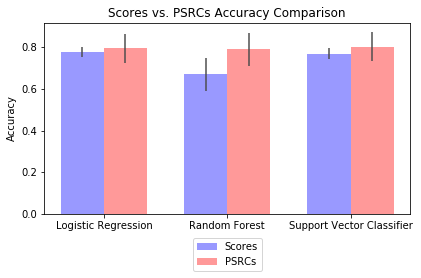

,PSRCs,Scores
logistic,0.796055,0.776240
randomforest,0.790463,0.671020
svc,0.803166,0.770019


In [38]:
run_and_diagnose(normalized_merged[SCORES_LIST], normalized_merged[FEATURES_LIST], 
                     normalized_merged[DRIVE_ALONE_THRESHOLD], 'Scores', 'PSRCs')

In [176]:
len(merged)

152

In [177]:
# to examine principal components
pca=PCA(n_components=4)
#pca.fit(normalized_res) 
#print(pca.components_)
pca.fit_transform(normalized_hh_merged[HH_FEATURES_LIST].values)
print(pca.explained_variance_ratio_)

pd.set_option('display.max_columns', 30)
pd.DataFrame(pca.components_, columns=normalized_hh_merged[HH_FEATURES_LIST].columns, index = ['PC-1','PC-2', 'PC-3', 'PC-4'])

[ 0.26955935  0.18722099  0.16768281  0.08506401]


,numchildren,hhincome_broad,hhsize,no_vehicle,home_ownership,mean_age,mean_duration,mean_distance,number_of_trips,year_residence,offpark
PC-1,0.442245,0.356468,0.478080,-0.356795,0.420904,-0.104620,-0.051165,-0.032024,0.197024,0.240777,-0.181510
PC-2,0.102690,0.074664,0.116262,0.037483,-0.107002,-0.365081,0.594035,0.595128,0.144658,-0.300291,0.077907
PC-3,-0.279264,0.119990,-0.204943,-0.085506,0.340212,0.530088,0.361589,0.360313,-0.144496,0.409160,-0.112697
PC-4,0.246517,-0.149596,0.248177,0.028552,-0.036552,0.054999,0.030100,0.063354,-0.359848,0.308981,0.787529


In [178]:
## Now, we use another data

In [179]:
pd.crosstab(index=scores[MODE],  # Make a crosstab
                              columns="count") / len(scores)

col_0,count
mode,
bicycling,0.039321
driving,0.484660
transit,0.164159
walking,0.311861


In [180]:
hh = pd.read_csv('processed_psrcdat.csv', index_col=0)
household = pd.read_excel('household.xlsx', header = 1)[[HOUSEHOLD_ID, HOUSEHOLD_BLOCKGROUP]]
household.rename(columns={HOUSEHOLD_BLOCKGROUP: BLOCKGROUP}, inplace=True)
hh = pd.merge(left=hh, right=household, on=HOUSEHOLD_ID)
hh.head()

,hhid,numchildren,hh_wt_revised,hhincome_broad,hhsize,vehicle_count,no_vehicle,home_ownership,offpark,year_residence,mean_age,proportion_white,mean_education_year,proportion_black,proportion_asian,...,prop_biking,prop_walking,mean_duration,mean_driving_duration,mean_transit_duration,mean_biking_duration,mean_walking_duration,prop_went_home,prop_went_work,prop_errands,prop_social,prop_gave_ride,number_of_trips,prop_driving_broad,blockgroup
0,17100024,1,26.224981,4.0,3,1,0,1.0,1,2,20.333333,1.0,6.0,0.0,0.0,...,0.214286,0.357143,5.071429,7.0,7.000000,5.0,2.800000,0.50000,0.285714,0.142857,0.000000,0.071429,14,0.357143,530330076002
1,17100052,0,25.692826,1.0,1,0,1,0.0,1,20,69.500000,1.0,6.0,0.0,0.0,...,0.000000,0.400000,5.400000,NaN,6.666667,NaN,3.500000,0.20000,0.000000,0.600000,0.200000,0.000000,5,0.000000,530330075005
2,17100059,0,47.768728,5.0,1,0,1,0.0,0,1,29.500000,0.0,4.0,0.0,0.0,...,0.000000,0.772727,18.921053,20.0,36.250000,NaN,7.176471,0.30303,0.272727,0.090909,0.333333,0.000000,38,0.045455,530330084001
3,17100102,0,318.861344,4.0,1,1,0,0.0,1,5,39.500000,1.0,6.0,0.0,1.0,...,0.000000,0.000000,46.000000,46.0,NaN,NaN,NaN,0.20000,0.200000,0.200000,0.000000,0.400000,5,1.000000,530330075004
4,17100108,0,24.899462,5.0,2,1,0,0.0,10,2,29.500000,0.0,6.0,0.0,0.0,...,0.000000,1.000000,14.750000,NaN,NaN,NaN,6.500000,0.50000,0.500000,0.000000,0.000000,0.000000,4,0.000000,530330080022


In [181]:
hh.columns

Index(['hhid', 'numchildren', 'hh_wt_revised', 'hhincome_broad', 'hhsize',
       'vehicle_count', 'no_vehicle', 'home_ownership', 'offpark',
       'year_residence', 'mean_age', 'proportion_white', 'mean_education_year',
       'proportion_black', 'proportion_asian', 'proportion_hispanic',
       'proportion_employed', 'proportion_student', 'proportion_female',
       'mean_distance', 'mean_depart_time', 'mean_num_travelers',
       'prop_driving_alone', 'prop_driving_with_others', 'prop_transit',
       'prop_biking', 'prop_walking', 'mean_duration', 'mean_driving_duration',
       'mean_transit_duration', 'mean_biking_duration',
       'mean_walking_duration', 'prop_went_home', 'prop_went_work',
       'prop_errands', 'prop_social', 'prop_gave_ride', 'number_of_trips',
       'prop_driving_broad', 'blockgroup'],
      dtype='object')

In [182]:
MEAN_LIST = [NUMBER_CHILDREN, HOUSEHOLD_INCOME, HOUSEHOLD_SIZE, NO_VEHICLE, 
           HOME_OWN, MEAN_AGE, MEAN_DURATION, MEAN_DURATION, 
           MEAN_DISTANCE, NUMBER_TRIPS, YEAR_RESIDENCE, OFF_PARK, PROP_DRIVING_ALONE]
MEAN_LIST

['numchildren',
 'hhincome_broad',
 'hhsize',
 'no_vehicle',
 'hh_own',
 'mean_age',
 'mean_duration',
 'mean_duration',
 'mean_distance',
 'number_of_trips',
 'year_residence',
 'offpark',
 'prop_driving_alone']

In [183]:
# looping over unique blockgroups
NUMBER_CHILDREN = 'numchildren'
HOUSEHOLD_INCOME = 'hhincome_broad'
HOUSEHOLD_SIZE = 'hhsize'
NO_VEHICLE = 'no_vehicle'
HOME_OWN = 'home_ownership'
MEAN_AGE = 'mean_age'
PROP_DRIVING_ALONE = 'prop_driving_alone'
MEAN_DURATION = 'mean_duration'
MEAN_DISTANCE = 'mean_distance'
NUMBER_TRIPS = 'number_of_trips'
YEAR_RESIDENCE = 'year_residence'
OFF_PARK = 'offpark'


HH_FEATURES_LIST = [NUMBER_CHILDREN, HOUSEHOLD_INCOME, HOUSEHOLD_SIZE, NO_VEHICLE, 
           HOME_OWN, MEAN_AGE, MEAN_DURATION, MEAN_DISTANCE, NUMBER_TRIPS, 
            YEAR_RESIDENCE, OFF_PARK]
MEAN_LIST = [NUMBER_CHILDREN, HOUSEHOLD_INCOME, HOUSEHOLD_SIZE, NO_VEHICLE, 
           HOME_OWN, MEAN_AGE, MEAN_DURATION, MEAN_DISTANCE, NUMBER_TRIPS, 
             YEAR_RESIDENCE, OFF_PARK, PROP_DRIVING_ALONE]


unique_clusters = hh[BLOCKGROUP].unique()
print(MEAN_LIST)
hh_result = pd.DataFrame([])
for i in unique_clusters:        
    # choose for each cluster
    sub_cluster = hh[hh[BLOCKGROUP] == i]
    
    one_row = np.array([i])
    for means in MEAN_LIST:
        one_row = np.append(one_row, calculate_weighted_mean(sub_cluster, means, HOUSEHOLD_WEIGHT))
    
    one_row = pd.DataFrame(one_row.reshape(-1, len(one_row)), 
                              columns = [BLOCKGROUP] + MEAN_LIST)
    hh_result = hh_result.append(one_row, ignore_index = True)
    
hh_result[DRIVE_ALONE_THRESHOLD] = np.where(hh_result[PROP_DRIVING_ALONE] >= hh_result[PROP_DRIVING_ALONE].median(),
                                           1, 0)
hh_result.head()

['numchildren', 'hhincome_broad', 'hhsize', 'no_vehicle', 'home_ownership', 'mean_age', 'mean_duration', 'mean_distance', 'number_of_trips', 'year_residence', 'offpark', 'prop_driving_alone']


,blockgroup,numchildren,hhincome_broad,hhsize,no_vehicle,home_ownership,mean_age,mean_duration,mean_distance,number_of_trips,year_residence,offpark,prop_driving_alone,drive_alone_threshold
0,5.303301e+11,0.038611,1.485804,1.188240,0.036630,0.038611,62.257534,8.997273,3.215526,14.414344,4.667724,8.249987,0.871598,1
1,5.303301e+11,0.000000,3.689819,1.812696,0.464206,0.347403,37.749596,9.939988,3.123367,5.350366,6.326215,0.442561,0.102329,0
2,5.303301e+11,0.050179,3.609506,1.766438,0.888207,0.015541,31.563039,199.169617,218.633110,9.666165,1.361761,2.784463,0.157263,0
3,5.303301e+11,0.000000,2.715333,1.097175,0.125233,0.000000,32.402170,22.756486,15.390673,6.340473,2.393195,0.806558,0.732005,1
4,5.303301e+11,0.105892,3.529634,1.479047,0.617640,0.306238,42.914713,9.680428,2.875315,11.661672,6.510753,4.366517,0.071765,0


In [184]:
hh_merged = pd.merge(left=features_set, right=hh_result, how='inner', on=BLOCKGROUP)
hh_merged.set_index(BLOCKGROUP, inplace=True)

# normalize data except the binary outcome
normalized_hh_merged = hh_merged[[DRIVE_ALONE_THRESHOLD]].copy()
normalized_hh_merged = normalized_hh_merged.join((hh_merged[HH_FEATURES_LIST]- hh_merged[HH_FEATURES_LIST].mean()) / hh_merged[HH_FEATURES_LIST].std())
normalized_hh_merged = normalized_hh_merged.join((hh_merged[SCORES_LIST]- hh_merged[SCORES_LIST].mean()) / hh_merged[SCORES_LIST].std())
normalized_hh_merged.head()

,drive_alone_threshold,numchildren,hhincome_broad,hhsize,no_vehicle,home_ownership,mean_age,mean_duration,mean_distance,number_of_trips,year_residence,offpark,mode_choice_score,affordability_score
blockgroup,,,,,,,,,,,,,,
530330001002,1,-0.518425,-2.550851,-1.132176,-0.635963,-1.246752,-0.863209,0.039379,0.100044,-0.795393,-1.035174,-0.686027,-3.608999,-0.320391
530330001003,0,1.361579,1.310954,1.263999,-0.635963,1.285586,-0.903546,-0.248381,-0.197524,-0.210948,1.914583,-0.216130,1.371949,0.566316
530330002002,1,3.241584,1.310954,2.462087,-0.635963,1.285586,-1.327084,-0.482043,-0.303966,0.214103,1.914583,-0.216130,1.310926,-0.320416
530330004011,1,-0.296082,-0.863245,-0.089969,-0.217294,-0.566844,0.552750,-0.124444,-0.132135,-0.099915,0.063064,1.015428,0.178460,-0.831146
530330004013,0,-0.488214,-1.265477,-0.505992,1.699803,-0.832538,1.665309,-0.364662,-0.248298,-0.450728,-0.405925,0.883340,0.043001,-1.241624


Summary: ModeChoice & Affordability Logistidc Regression with 5-fold CV Accuracy: 0.60 (+/- 0.15)


Summary: ModeChoice & Affordability Random Forest Classifier with 5-fold CV Accuracy: 0.51 (+/- 0.19)


Summary: ModeChoice & Affordability Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.59 (+/- 0.16)


Summary: Duration & Distance & Income Logistidc Regression with 5-fold CV Accuracy: 0.72 (+/- 0.06)


Summary: Duration & Distance & Income Random Forest Classifier with 5-fold CV Accuracy: 0.67 (+/- 0.12)


Summary: Duration & Distance & Income Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.71 (+/- 0.06)




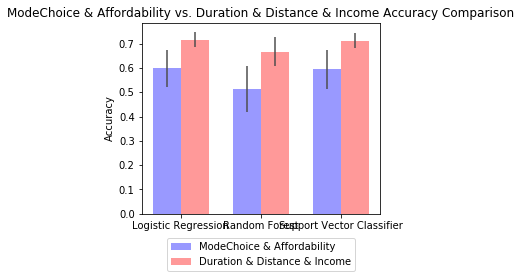

,Duration & Distance & Income,ModeChoice & Affordability
logistic,0.717236,0.598433
randomforest,0.668091,0.514530
svc,0.713390,0.594587


In [185]:
run_and_diagnose(normalized_hh_merged[SCORES_LIST], 
                 normalized_hh_merged[[MEAN_DURATION, MEAN_DISTANCE, NO_VEHICLE]], 
                 normalized_hh_merged[DRIVE_ALONE_THRESHOLD], 
                'ModeChoice & Affordability', 'Duration & Distance & Income')

Summary: ModeChoice & Affordability Logistidc Regression with 5-fold CV Accuracy: 0.60 (+/- 0.15)


Summary: ModeChoice & Affordability Random Forest Classifier with 5-fold CV Accuracy: 0.51 (+/- 0.19)


Summary: ModeChoice & Affordability Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.59 (+/- 0.16)


Summary: All Features Logistidc Regression with 5-fold CV Accuracy: 0.75 (+/- 0.12)


Summary: All Features Random Forest Classifier with 5-fold CV Accuracy: 0.75 (+/- 0.13)


Summary: All Features Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.76 (+/- 0.11)




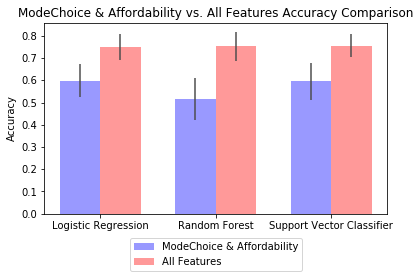

,All Features,ModeChoice & Affordability
logistic,0.751282,0.598433
randomforest,0.752422,0.514530
svc,0.755128,0.594587


In [186]:
run_and_diagnose(normalized_hh_merged[SCORES_LIST], 
                 normalized_hh_merged[HH_FEATURES_LIST], 
                 normalized_hh_merged[DRIVE_ALONE_THRESHOLD], 
                'ModeChoice & Affordability', 'All Features')

In [339]:
hh_merged.to_csv('Personadata_for_prediction.csv')

In [15]:
features_set.to_csv('scores_from_psrc.csv')

In [136]:
normalized_hh_merged.columns

Index(['drive_alone_threshold', 'numchildren', 'hhincome_broad', 'hhsize',
       'no_vehicle', 'home_ownership', 'mean_age', 'mean_duration',
       'mean_distance', 'number_of_trips', 'year_residence', 'offpark',
       'mode_choice_score', 'affordability_score'],
      dtype='object')

Summary: ModeChoice & Affordability Logistidc Regression with 5-fold CV Accuracy: 0.60 (+/- 0.15)


Summary: ModeChoice & Affordability Random Forest Classifier with 5-fold CV Accuracy: 0.51 (+/- 0.19)


Summary: ModeChoice & Affordability Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.59 (+/- 0.16)


Summary: Duration & Distance & Income Logistidc Regression with 5-fold CV Accuracy: 0.72 (+/- 0.03)


Summary: Duration & Distance & Income Random Forest Classifier with 5-fold CV Accuracy: 0.73 (+/- 0.06)


Summary: Duration & Distance & Income Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.73 (+/- 0.04)




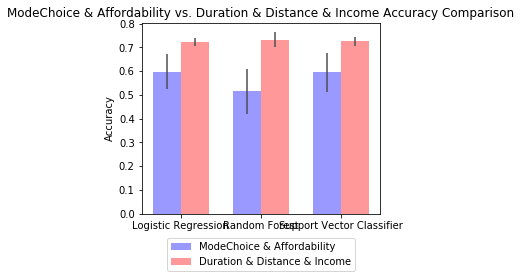

,Duration & Distance & Income,ModeChoice & Affordability
logistic,0.721225,0.598433
randomforest,0.732906,0.514530
svc,0.725214,0.594587


In [138]:
# HH_FEATURES_LIST2= [NUMBER_CHILDREN, HOUSEHOLD_INCOME, HOUSEHOLD_SIZE, NO_VEHICLE, 
#            HOME_OWN, MEAN_AGE, MEAN_DURATION, MEAN_DISTANCE, NUMBER_TRIPS, 
#             YEAR_RESIDENCE, OFF_PARK]

HH_FEATURES_LIST2 = [NO_VEHICLE, MEAN_DURATION, MEAN_DISTANCE, 
            YEAR_RESIDENCE, HOME_OWN]

run_and_diagnose(normalized_hh_merged[SCORES_LIST], 
                 normalized_hh_merged[HH_FEATURES_LIST2], 
                 normalized_hh_merged[DRIVE_ALONE_THRESHOLD], 
                'ModeChoice & Affordability', 'Duration & Distance & Income')

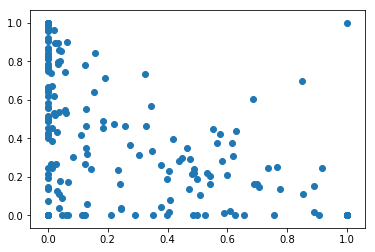

In [63]:
plt.scatter(hh_merged[NO_VEHICLE], hh_merged[HOME_OWN])

In [196]:
MODE_INDEX = 'mode_index'
SCALED = 'scaled'
MODE_CHOIDE_SCORE_NEW = 'mode_choice_score_new'
AFFORDABILITY_SCORE_NEW = 'affordability_score_new'
ABOVE_MEDIAN = 'prop_driving_above_median'
RELATIVE_SCALED = 'relative_scaled'
# load features/covariates and normalize the values

new_mode_choice = pd.read_csv('true_final/final_mode_choice_081418.csv')[[BLOCKGROUP_MODE_CHOICE, MODE_INDEX]]
new_mode_choice.rename(columns = {BLOCKGROUP_MODE_CHOICE: BLOCKGROUP, 
                              MODE_INDEX: MODE_CHOIDE_SCORE_NEW}, inplace=True)


new_affordability = pd.read_csv('true_final/final_affordability_081418.csv')[[BLOCKGROUP_AFFORDABILITY, RELATIVE_SCALED]]
new_affordability.rename(columns = {BLOCKGROUP_AFFORDABILITY: BLOCKGROUP, 
                               RELATIVE_SCALED: AFFORDABILITY_SCORE_NEW}, inplace=True)

In [197]:
new_features_set = pd.merge(left=new_mode_choice, right=new_affordability, on=BLOCKGROUP)
new_features_set.set_index(BLOCKGROUP, inplace=True)
new_features_set.head()

,mode_choice_score_new,affordability_score_new
blockgroup,,
530330100023,0.781429,0.339924
530330107023,0.691429,0.454073
530330110013,0.654286,0.104318
530330020003,0.794286,0.539485
530330080015,0.801429,0.636726


In [198]:
len(new_affordability)

481

In [199]:
new_normalized_hh_merged = normalized_hh_merged.join(new_features_set)
len(new_normalized_hh_merged)

262

In [201]:
new_normalized_hh_merged.head()

,drive_alone_threshold,numchildren,hhincome_broad,hhsize,no_vehicle,home_ownership,mean_age,mean_duration,mean_distance,number_of_trips,year_residence,offpark,mode_choice_score,affordability_score,mode_choice_score_new,affordability_score_new
blockgroup,,,,,,,,,,,,,,,,
530330001002,1,-0.518425,-2.550851,-1.132176,-0.635963,-1.246752,-0.863209,0.039379,0.100044,-0.795393,-1.035174,-0.686027,-3.608999,-0.320391,0.655714,0.400255
530330001003,0,1.361579,1.310954,1.263999,-0.635963,1.285586,-0.903546,-0.248381,-0.197524,-0.210948,1.914583,-0.216130,1.371949,0.566316,0.652143,0.413378
530330002002,1,3.241584,1.310954,2.462087,-0.635963,1.285586,-1.327084,-0.482043,-0.303966,0.214103,1.914583,-0.216130,1.310926,-0.320416,0.601429,0.396987
530330004011,1,-0.296082,-0.863245,-0.089969,-0.217294,-0.566844,0.552750,-0.124444,-0.132135,-0.099915,0.063064,1.015428,0.178460,-0.831146,0.650714,0.379529
530330004013,0,-0.488214,-1.265477,-0.505992,1.699803,-0.832538,1.665309,-0.364662,-0.248298,-0.450728,-0.405925,0.883340,0.043001,-1.241624,0.652857,0.197513


In [204]:
new_normalized_hh_merged[NEW_SCORES_LIST]

,mode_choice_score_new,affordability_score_new
blockgroup,,
530330001002,0.655714,0.400255
530330001003,0.652143,0.413378
530330002002,0.601429,0.396987
530330004011,0.650714,0.379529
530330004013,0.652857,0.197513
530330005003,0.552857,0.217071
530330006003,0.697857,0.243381
530330007001,0.658571,0.430777
530330007003,0.645000,0.148033


Summary: ModeChoice & Affordability Logistidc Regression with 5-fold CV Accuracy: 0.63 (+/- 0.11)


Summary: ModeChoice & Affordability Random Forest Classifier with 5-fold CV Accuracy: 0.53 (+/- 0.04)


Summary: ModeChoice & Affordability Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.63 (+/- 0.10)


Summary: Duration & Distance & Income Logistidc Regression with 5-fold CV Accuracy: 0.75 (+/- 0.12)


Summary: Duration & Distance & Income Random Forest Classifier with 5-fold CV Accuracy: 0.75 (+/- 0.13)


Summary: Duration & Distance & Income Support Vector Classifier with Linear Kernel with 5-fold CV Accuracy: 0.76 (+/- 0.11)




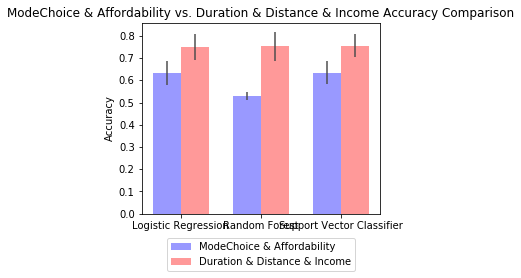

,Duration & Distance & Income,ModeChoice & Affordability
logistic,0.751282,0.633333
randomforest,0.752422,0.530342
svc,0.755128,0.633333


In [203]:
NEW_SCORES_LIST = [MODE_CHOIDE_SCORE_NEW, AFFORDABILITY_SCORE_NEW]
NEW_SCORES_LIST = ['mode_choice_score_new', 'affordability_score_new']
run_and_diagnose(new_normalized_hh_merged[NEW_SCORES_LIST], 
                 new_normalized_hh_merged[HH_FEATURES_LIST], 
                 new_normalized_hh_merged[DRIVE_ALONE_THRESHOLD], 
                'ModeChoice & Affordability', 'Duration & Distance & Income')